# Truss Snap-Through

In [1]:
import ema as em
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import brentq
%config InlineBackend.figure_format = 'svg'

In [2]:
class pfTruss ( em.Truss ):
    #Number of dofs per element
#     dofTypes = ['u','v']
    
    def __init__ (self, tag, iNode, jNode, E, A):
        super().__init__( tag, iNode, jNode, E, A)

        #Initialize the history parameter
        self.setHistoryParameter( 'sigma', 0. )
        self.commitHistory()
    
    def kt_matrix ( self ):

        #Compute l0 and strains
        L0 = self.L0
        E  = self.E 
        A  = self.A 
    
        Depsilon = self.iGLstrain( )

        # Compute the stress increment 
        Dsigma = self.E * Depsilon

        # Compute the current stress 
        sigma = self.getHistoryParameter('sigma') + Dsigma

        #Update the history parameter
        self.setHistoryParameter( 'sigma', sigma )

        # Compute the local element stiffness
        KL = self.k_matrix()

        KNL = self.getKNL( sigma )

        elStiff = KL + KNL

       # Rotate element tangent stiffness to the global coordinate system
        T = self.Rz_matrix()
        k = elStiff
#         k_global = T.T @ k @ T
        return k
    
    

    def getStrain( self , a , a0 ):

        epsilon  = (a[2]-a[0])/self.L0 + 0.5*((a[2]-a[0])/self.L0)**2 + 0.5*((a[3]-a[1])/self.L0)**2
        epsilon0 = (a0[2]-a0[0])/self.L0 + 0.5*((a0[2]-a0[0])/self.L0)**2 + 0.5*((a0[3]-a0[1])/self.L0)**2

        #Compute the strain increment
        Depsilon = epsilon -epsilon0

        return epsilon, Depsilon

    #-------------------------------------------

    def getBL( self , a ):

        BL = np.zeros( 4 )

        BL[0] = (-1.0/self.L0)*(1.0+(a[2]-a[0])/self.L0)
        BL[1] = (-1.0/self.L0)*(a[3]-a[1])/self.L0
        BL[2] = -BL[0]
        BL[3] = -BL[1]

        return BL
    #-------------------------------------------

    def getKNL( self , sigma ):
        A0 = self.A

        KNL = np.zeros( (4,4) )

        KNL[:2,:2] =  (sigma * A0/self.L0)*np.eye(2)
        KNL[:2,2:] = -(sigma * A0/self.L0)*np.eye(2)
        KNL[2:,:2] = KNL[:2,2:]
        KNL[2:,2:] = KNL[:2,:2]

        return KNL


In [3]:
mdl = em.Model(2,2)
n = mdl.dnodes
e = mdl.delems

mdl.material('default', 20000)

DY = 0.5
DX = 10
E = 5e6
A = 1.0

mdl.node('1', 0,  0)
mdl.node('2', DX, DY)

a = pfTruss('a',n['1'], n['2'], E, A)
mdl.add_element(a)


mdl.pin(n['1'])
mdl.fix(n['2'], 'x')
mdl.numDOF()

[[2, 3], [4, 1]]

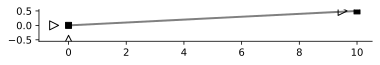

In [4]:
fig, ax = plt.subplots()
em.plot_structure(mdl, ax)

In [5]:
a.kt_matrix()

,0,1,2,3
0,499376.169439,499376.169439,499376.169439,499376.169439
1,499376.169439,499376.169439,499376.169439,499376.169439
2,499376.169439,499376.169439,499376.169439,499376.169439
3,499376.169439,499376.169439,499376.169439,499376.169439


In [9]:
a.ke_matrix()

,0,1,2,3
0,498130.842333,24906.542117,-498130.842333,-24906.542117
1,24906.542117,1245.327106,-24906.542117,-1245.327106
2,-498130.842333,-24906.542117,498130.842333,24906.542117
3,-24906.542117,-1245.327106,24906.542117,1245.327106


In [7]:
n['2'].p['y'] = P

NameError: name 'P' is not defined

In [ ]:
A = em.A_matrix(mdl)
def solve_snap(N):
    a.Q[0] = N
    Uf, P = em.analysis.SolveDispl(mdl)
    Ks = em.Ks_matrix(mdl)
    Q0 = em.Q0_vector(mdl)
    Q = Ks@A.f@Uf + Q0
    return Q - N


In [ ]:
P = np.linspace(-10, 10, 100)
N = []
Ufi = []
n['2'].x = n['2'].x_ref
n['2'].y = n['2'].y_ref
for p in P:
    n['2'].p['y'] = p
    N.append(brentq(solve_snap,-3000,300))
    Uf, Pf = em.analysis.SolveDispl(mdl)
    Ufi.append(Uf)
    mdl.update(Uf)

In [ ]:
# fig2, ax2 = plt.subplots()
plt.plot(P, N)

In [ ]:
plt.plot(P, Ufi)

In [ ]:
Ufi[78]

In [ ]:
n['2'].y

In [ ]:
plt.show()